In [1]:
import numpy as np
import scipy as sp
import sympy as smp
from scipy.integrate import solve_ivp
import snoop
from findiff import FinDiff

import matplotlib.pyplot as plt
import itertools

In [2]:
"""
Reference Paper:
https://doi.org/10.1046/j.1365-8711.1999.02754.x
"""

'\nReference Paper:\nhttps://doi.org/10.1046/j.1365-8711.1999.02754.x\n'

In [3]:
%load_ext snoop

In [13]:
# Metric or Black Hole parameters - Mass, M and Spin Parameter, a
M = 1

In [14]:
Vin = 0.5  # Relative velocity in the units of c

alpha_s = 0.0
beta_s = np.pi / 2  # Angular Coordinates for spin Orientation

alpha_v = 0.0
beta_v = np.pi / 2  # Angular Coordinates for Velocity Orientation

sin = 0.0  # Initial Magnitude of Spin

a0 = 1 / np.sqrt(2)
r0 = 10**6
theta0 = np.pi / 2  # Parameters for Black Hole and the Particle Position
m=1e-6 #Mass of Secondary


In [15]:
# Definitions
Delta = a0**2 - 2 * M * r0 + r0**2
scA = (r0**2 + a0**2) ** 2 - Delta * a0**2 * np.sin(theta0) ** 2
omega_k = 2 * M * a0 * r0 / scA
Sigma = r0**2 + a0**2 * np.cos(theta0) ** 2

In [4]:


#Define Levi Cevita Tensor
def levi_cevita_tensor(dim):
    arr = np.zeros(tuple([dim for _ in range(dim)]))
    for x in itertools.permutations(tuple(range(dim))):
        mat = np.zeros((dim, dim), dtype=np.int32)
        for i, j in zip(range(dim), x):
            mat[i, j] = 1
        arr[x] = int(np.linalg.det(mat))
    return arr

In [5]:
def antisymmetrize(arr):
    #* Function to antisymmetrize matrix
    arr = np.swapaxes(arr, -2, -1)
    anti_arr = arr - np.swapaxes(arr, -2, -1)
    anti_tensor=np.swapaxes(anti_arr,-2,-1)
    return anti_tensor

In [6]:
def symmetrize(arr):
    """
    Symmetrizes a 4-dimensional numpy array along last two axes.

    Args:
        arr (numpy.ndarray): The input array.

    Returns:
        numpy.ndarray: The symmetrized array.

    Example:

        arr = np.array([[[1, 2, 3, 4],
                         [5, 6, 7, 8],
                         [9, 10, 11, 12],
                         [13, 14, 15, 16]]])

        result = symmetrize(arr)
        print(result)
    """

    toput = np.diagonal(arr, 0, 1, 2)
    de_ = np.zeros((4, 4, 4))


    idx = np.arange(de_.shape[0])
    de_[:, idx, idx] = toput

    return arr+np.transpose(arr,(0,2,1))-de_

In [7]:
def metric_tensor(r, theta,a,M=1):
    """
    Define the metric tensor function.

    Parameters:
        a (float): Parameter 'a' in the metric.
        r (float): Parameter 'r' in the metric.
        theta (float): Parameter 'theta' in the metric.

    Returns:
        np.ndarray: The metric tensor at the given values of a, r, and theta.
    """
    g = np.array(
        [
            [
                (-(a**2) + 2 * M * r - r**2 + a**2 * np.sin(theta) ** 2)
                / (r**2 + a**2 * np.cos(theta) ** 2),
                0,
                0,
                -(
                    (2 * a * M * r * np.sin(theta) ** 2)
                    / (r**2 + a**2 * np.cos(theta) ** 2)
                ),
            ],
            [
                0,
                (r**2 + a**2 * np.cos(theta) ** 2) / (a**2 - 2 * M * r + r**2),
                0,
                0,
            ],
            [0, 0, r**2 + a**2 * np.cos(theta) ** 2, 0],
            [
                -(
                    (2 * a * M * r * np.sin(theta) ** 2)
                    / (r**2 + a**2 * np.cos(theta) ** 2)
                ),
                0,
                0,
                (
                    np.sin(theta) ** 2
                    * (
                        (a**2 + r**2) ** 2
                        - a**2 * (a**2 - 2 * M * r + r**2) * np.sin(theta) ** 2
                    )
                )
                / (r**2 + a**2 * np.cos(theta) ** 2),
            ],
        ]
    )

    return g

In [8]:
def kerr_christoffel(r, theta, a, M=1):

    """
    Function to give the christoffel symbols for kerr metric.
    The christoffel symbols are given as \Gamma ^i _{jk}

    From Reference Paper, Appendix
    """
    
    cs = np.zeros((4, 4, 4))

    # Definitions
    Delta = a**2 - 2 * M * r + r**2
    scA = (r**2 + a**2) ** 2 - Delta * a**2 * np.sin(theta) ** 2
    omega_k = 2 * M * a * r / scA
    Sigma = r**2 + a**2 * np.cos(theta) ** 2

    cs[3, 0, 1] = M * (2 * r**2 - Sigma) / (Delta * Sigma**2) * a
    cs[0, 0, 1] = cs[3, 0, 1] * (r**2 + a**2) / a

    cs[3, 0, 2] = -2 * M * a * r / (np.tan(theta) * Sigma**2)
    cs[0, 0, 2] = a * np.sin(theta) ** 2 * cs[3, 0, 2]

    cs[0, 1, 3] = (
        -M
        * a
        * (2 * r**2 * (r**2 + a**2) + Sigma * (r**2 - a**2))
        * np.sin(theta) ** 2
        / (Delta * Sigma**2)
    )

    cs[3, 1, 3] = (
        r * Sigma * (Sigma - 2 * M * r)
        - M * a**2 * (2 * r**2 - Sigma) * np.sin(theta) ** 2
    ) / (Delta * Sigma**2)

    cs[0, 2, 3] = M * a**3 * r * np.sin(theta) ** 2 * np.sin(2 * theta) / Sigma**2

    cs[3, 2, 3] = (scA - Sigma * a**2 * np.sin(theta) ** 2) / (
        np.tan(theta) * Sigma**2
    )

    cs[1, 0, 0] = M * Delta * (2 * r**2 - Sigma) / Sigma**3

    cs[1, 0, 3] = -cs[1, 0, 0] * a * np.sin(theta) ** 2

    cs[2, 0, 0] = -M * a * r * np.sin(2 * theta) / Sigma**3 * a
    cs[2, 0, 3] = -cs[2, 0, 0] * (r**2 + a**2) / a

    cs[1, 1, 1] = r / Sigma + (M - r) / Delta

    cs[1, 2, 2] = -r * Delta / Sigma
    cs[2, 1, 2] = -cs[1, 2, 2] / Delta

    cs[1, 1, 2] = cs[2, 2, 2] = -(a**2) * np.sin(2 * theta) / (2 * Sigma)
    cs[2, 1, 1] = -cs[1, 1, 2] / Delta

    cs[1, 3, 3] = (
        -Delta
        * (r * Sigma**2 - M * a**2 * (2 * r**2 - Sigma) * np.sin(theta) ** 2)
        * np.sin(theta) ** 2
        / Sigma**3
    )

    cs[2, 3, 3] = (
        -(Delta * Sigma**2 + 2 * M * r * (r**2 + a**2) ** 2)
        * np.sin(2 * theta)
        / (2 * Sigma**3)
    )

    return symmetrize(cs)
    # return cs

In [9]:
def dmetric(r,theta,a,c=0,M=1):
    """
    Function to give the derivative of metric with respect to
    some component of position vector

    The function calculates the derivative with respect to all the 
    elements but only returns the component c
    """

    g=metric_tensor(a,r,theta)
    cs=kerr_christoffel(r,theta,a,M)

    term1=np.einsum('mk,mil->kil',g,cs)
    term2= np.einsum('im,mkl->ikl',g,cs)

    dg=term1+term2

    return dg[c]




In [10]:
def kerr_riemann_tensor(r, theta, a, M=1, config="ulll"):
    # Define variables

    # Components of the Riemann tensor for Kerr Metric
    # From Reference Paper, Appendix
    
    rijkl = np.zeros((4, 4, 4, 4))

    X = r**2 - 3 * a**2 * np.cos(theta) ** 2
    Y = 3 * r**2 - a**2 * np.cos(theta) ** 2

    # Definitions
    Delta = a**2 - 2 * M * r + r**2
    scA = (r**2 + a**2) ** 2 - Delta * a**2 * np.sin(theta) ** 2
    omega_k = 2 * M * a * r / scA
    Sigma = r**2 + a**2 * np.cos(theta) ** 2

    rijkl[0, 0, 0, 3] = 2 * M**2 * a * r**2 * X * np.sin(theta) ** 2 / Sigma**4
    rijkl[3, 3, 0, 3] = -rijkl[0, 0, 0, 3]
    rijkl[0, 3, 0, 3] = -rijkl[0, 0, 0, 3] / omega_k
    rijkl[3, 0, 0, 3] = -rijkl[0, 0, 0, 3] / (
        2 * M * a * r / (Delta - a**2 * np.sin(theta) ** 2)
    )

    rijkl[0, 0, 1, 2] = -(
        M**2 * a**2 * r * Y * np.sin(2 * theta) / (Delta * Sigma**3)
    )
    rijkl[3, 3, 1, 2] = -rijkl[0, 0, 1, 2]
    rijkl[0, 3, 1, 2] = -rijkl[0, 0, 1, 2] / omega_k
    rijkl[3, 0, 1, 2] = -rijkl[0, 0, 1, 2] / (
        2 * M * a * r / (Delta - a**2 * np.sin(theta) ** 2)
    )

    rijkl[3, 2, 2, 3] = -(
        M * r * X * (2 * (r**2 + a**2) + a**2 * np.sin(theta) ** 2) / Sigma**3
    )

    rijkl[0, 1, 0, 1] = -rijkl[3, 2, 2, 3] / Delta

    rijkl[0, 2, 0, 2] = -(
        M * r * X * ((r**2 + a**2) + 2 * a**2 * np.sin(theta) ** 2) / Sigma**3
    )

    rijkl[3, 1, 1, 3] = -rijkl[0, 2, 0, 2] / Delta

    rijkl[0, 1, 0, 2] = rijkl[3, 2, 1, 3] = (
        -M
        * a**2
        / (Delta * Sigma**3)
        * Y
        * (3 * (r**2 + a**2) - 2 * M * r)
        * np.sin(theta)
        * np.cos(theta)
    )

    rijkl[0, 2, 0, 1] = rijkl[3, 2, 1, 3] = (
        -M
        * a**2
        / (Delta * Sigma**3)
        * Y
        * (3 * (r**2 + a**2) - 4 * M * r)
        * np.sin(theta)
        * np.cos(theta)
    )

    rijkl[3, 2, 0, 2] = -3 * M * a * r * X / Sigma**3
    rijkl[3, 1, 0, 1] = -rijkl[3, 2, 0, 2] / Delta

    rijkl[0, 2, 2, 3] = rijkl[3, 2, 0, 2] * np.sin(theta) ** 2 * (r**2 + a**2)
    rijkl[0, 1, 1, 3] = -rijkl[0, 2, 2, 3] / Delta

    rijkl[1, 0, 0, 2] = (
        -3 * M * a**2 * Delta / Sigma**4 * Y * np.sin(theta) * np.cos(theta)
    )
    rijkl[2, 0, 0, 1] = rijkl[1, 0, 0, 2] / Delta

    rijkl[1, 0, 1, 3] = (
        M
        * a
        * r
        / Sigma**4
        * X
        * np.sin(theta) ** 2
        * (3 * (r**2 + a**2) - 4 * M * r)
    )
    rijkl[1, 3, 0, 1] = -rijkl[1, 0, 1, 3]

    rijkl[2, 0, 2, 3] = -(
        M
        * a
        * r
        / Sigma**4
        * X
        * np.sin(theta) ** 2
        * (3 * (r**2 + a**2) - 2 * M * r)
    )

    rijkl[2, 3, 0, 2] = -rijkl[2, 0, 2, 3]

    rijkl[1, 0, 2, 3] = (
        -M
        * a
        * Delta
        / Sigma**4
        * Y
        * np.sin(theta)
        * np.cos(theta)
        * (2 * (r**2 + a**2) + a**2 * np.sin(theta) ** 2)
    )
    rijkl[2, 3, 0, 1] = -rijkl[1, 0, 2, 3] / Delta

    rijkl[1, 3, 0, 2] = (
        M
        * a
        * Delta
        / Sigma**4
        * Y
        * np.sin(theta)
        * np.cos(theta)
        * ((r**2 + a**2) + 2 * a**2 * np.sin(theta) ** 2)
    )

    rijkl[2, 0, 1, 3] = -rijkl[1, 3, 0, 2] / Delta

    rijkl[1, 2, 0, 3] = Delta**2 * rijkl[0, 0, 1, 2] / (2 * M * a * r)
    rijkl[2, 1, 0, 3] = -rijkl[1, 2, 0, 3] / Delta

    rijkl[1, 3, 2, 3] = -(r**2 + a**2) * np.sin(theta) ** 2 * rijkl[1, 0, 0, 2]
    rijkl[2, 3, 1, 3] = rijkl[1, 3, 2, 3] / Delta

    rijkl[1, 2, 1, 2] = -M * r * X / Sigma**2
    rijkl[2, 1, 1, 2] = -rijkl[1, 2, 1, 2] / Delta

    rijkl[0, 1, 2, 3] = (
        -M
        * a
        * Y
        * (2 * (r**2 + a**2) ** 2 + Delta * a**2 * np.sin(theta) ** 2)
        * np.sin(theta)
        * np.cos(theta)
        / (Delta * Sigma**3)
    )
    rijkl[0, 2, 1, 3] = (
        -M
        * a
        * Y
        * ((r**2 + a**2) ** 2 + 2 * Delta * a**2 * np.sin(theta) ** 2)
        * np.sin(theta)
        * np.cos(theta)
        / (Delta * Sigma**3)
    )

    rijkl[3, 1, 0, 2] = (
        -M
        * a
        * Y
        * (Delta + 2 * a**2 * np.sin(theta) ** 2)
        / (np.tan(theta) * Delta * Sigma**3)
    )
    rijkl[3, 2, 0, 1] = (
        -M
        * a
        * Y
        * (2 * Delta + a**2 * np.sin(theta) ** 2)
        / (np.tan(theta) * Delta * Sigma**3)
    )

    rijkl[1, 0, 0, 1] = (
        M * r * X * (2 * Delta + a**2 * np.sin(theta) ** 2) / Sigma**4
    )

    rijkl[2, 0, 0, 2] = -(
        M * r * X * (Delta + 2 * a**2 * np.sin(theta) ** 2) / Sigma**4
    )

    rijkl[1, 3, 1, 3] = (
        -M
        * r
        * X
        * ((r**2 + a**2) ** 2 + 2 * Delta * a**2 * np.sin(theta) ** 2)
        * np.sin(theta) ** 2
        / Sigma**4
    )
    rijkl[2, 3, 2, 3] = (
        M
        * r
        * X
        * (2 * (r**2 + a**2) ** 2 + Delta * a**2 * np.sin(theta) ** 2)
        * np.sin(theta) ** 2
        / Sigma**4
    )

    if config == "ulll":
        return antisymmetrize(rijkl)
    else:
        return np.einsum("ij,jklm->iklm", metric_tensor(a, r, theta), rijkl)

In [11]:
def momentas(rsol):
    """
    Function returns the momentas given the current 4-position vectors
    """
    
    guv=metric_tensor(rsol[1],rsol[2],a=a0)
    p=rsol[4:8]
    return np.einsum('ij,j->i',guv,p)

In [12]:
def get_constants(rsol):

    """
    Helper Function which outputs the Conserved Energy
    and Conserved Angular Momentum. For Spin Case, these are only two
    Constant of Motion
    """

    E = np.zeros(len(rsol))
    Phi = np.zeros(len(rsol))

    for i in range(len(rsol)):
        term1 = momentas(rsol[i])
        dg = dmetric( rsol[i][1], rsol[i][2], a=a0,c=[0, 3])
        suv = rsol[i][8:].reshape((4, 4))

        term2 = np.einsum("jk,jk->", dg[0], suv) * 0.5
        term22 = np.einsum("jk,jk->", dg[1], suv) * 0.5

        E[i]=m * (term2 - term1[0])
        Phi[i]=m * (term2-term1[3])

    return E, Phi

In [16]:
# Initial Velocity
uhoo = np.sqrt(scA / (Delta * Sigma)) * np.array([1, 0, 0, omega_k])

In [17]:
uhoo

array([1.00000100e+00, 0.00000000e+00, 0.00000000e+00, 1.41421498e-18])

In [18]:
gk=metric_tensor(r0,np.pi/2,a0)

In [19]:
# Tensor components calculation

v4,s4= smp.symbols('v4 s4')

V_sigma = np.array(
    [
        v4,
        Vin * np.cos(alpha_v),
        Vin * np.sin(alpha_v) * np.cos(beta_v),
        Vin * np.sin(alpha_v) * np.sin(beta_v),
    ]
)


S_sigma = np.array(
    [
        s4,
        sin * np.cos(alpha_s),
        sin * np.sin(alpha_s) * np.cos(beta_s),
        sin * np.sin(alpha_s) * np.sin(beta_s),
    ]
)

In [20]:
dum_1=np.einsum('ij,j->i',gk,uhoo)

In [21]:
v4=smp.solve(np.einsum("i,i", dum_1, V_sigma), v4)[0]
s4=smp.solve(np.einsum("i,i", dum_1, S_sigma), s4)[0]

In [22]:
# Tensor components calculation

V_sigmain = np.array(
    [
        v4,
        Vin * np.cos(alpha_v),
        Vin * np.sin(alpha_v) * np.cos(beta_v),
        Vin * np.sin(alpha_v) * np.sin(beta_v),
    ]
)


S_sigmain = np.array(
    [
        s4,
        sin * np.cos(alpha_s),
        sin * np.sin(alpha_s) * np.cos(beta_s),
        sin * np.sin(alpha_s) * np.sin(beta_s),
    ]
)

In [23]:
#Sanity Check


In [24]:
np.einsum("i,i", np.einsum("ij,j", gk, V_sigmain), uhoo), np.einsum(
    "i,i", np.einsum("ij,j", gk, S_sigmain), uhoo
)

(0, 0)

In [25]:
Gamma=1/np.sqrt(1-Vin**2)

In [26]:
Umu = (uhoo + V_sigmain) * Gamma

In [27]:
dMult=np.einsum('i,jk,j,k->i',uhoo,gk,V_sigmain,S_sigmain)

In [28]:
scS=Gamma*(dMult+S_sigmain)

In [29]:
epsilon=levi_cevita_tensor(4)

In [30]:
Sepsilon = np.einsum("mnjl,ij,kl->mnik",epsilon, gk, gk)

In [31]:
scM=1e-6

In [32]:
SinM=scS/scM

In [33]:
MSinM=sin/scM

In [34]:
Suvin=np.einsum('ijkl,k,l->ij',Sepsilon,Umu,SinM)

In [41]:
y0 = np.zeros(24)
y0[:4] = [0.0, r0, theta0, 0.0]
y0[4:8] = Umu.flatten()
y0[8:] = Suvin.flatten()

In [35]:
def Sbar(csu):

    a,b,c,d,e,f= csu
    # Create a 4x4 antisymmetric matrix

    antisymmetric_matrix = np.array(
    [[0, a, b, c], [-a, 0, d, e], [-b, -d, 0, f], [-c, -e, -f, 0]]
)
    
    return antisymmetric_matrix

In [36]:
# @snoop
def rhs40(y,Umu,sbaruv):
    """
    The RHS of Equation 40 in Paper
    """

    t,r,theta,phi=y
    rijkl=kerr_riemann_tensor(r=r,theta=theta,a=a0,config='llll')
    guv= metric_tensor(r=r0,theta=theta,a=a0)

    num = 2*np.einsum("ij,jklm,k,lm->i",sbaruv,rijkl,Umu,sbaruv)
    den = 4+ np.einsum("abcd,ab,cd-> ",rijkl,sbaruv,sbaruv)

    umu=Umu+ num/den

    norm_= np.einsum("ij,j->i",guv,umu)
    norm=np.einsum("i,i->",norm_,umu)

    umu=umu/np.sqrt(-norm)

    return umu
    

In [37]:
def rhs41(y, Umu, sbaruv, umu):

    """
    The RHS of Equation 41 in Paper
    """
    
    t, r, theta, phi = y
    rijkl = kerr_riemann_tensor(r=r, theta=theta, a=a0)
    cs = kerr_christoffel(r, theta, a=a0)

    term1 = np.einsum("ijkl,kl->ij", rijkl, sbaruv) * 0.5
    term2 = np.einsum("ijk,k", cs, Umu)

    term = -(term1 + term2)

    dUmu = np.einsum("ij,j->i", term, umu)

    return dUmu

In [38]:
def rhs42(y, Umu, umu, sbaruv):
    """
    The RHS of Equation 42 in Paper
    """

    t, r, theta, phi = y
    cs = kerr_christoffel(r, theta, a=a0)

    term1 = np.einsum("i,j->ij", Umu, umu)
    term1 = (term1 - term1.T) / 2

    term2 = np.einsum("ijk,lj,k->il", cs, sbaruv, umu)
    term2 = (term2 - term2.T) / 2

    dSuv = 2 * (term1 + term2)

    return dSuv

In [39]:
def rhs43(umu):
    return umu

In [40]:
#The Initial Vector has following components:
#y[:4]= t,r, theta, phi
#y[4:8]= Inital 4-Velocity
#y[8:]= Initial component of Spin

In [43]:
def mpd(t,y):
    """
    Solve the MPD Equations Given the Initial Conditions
    """

    dy=np.zeros_like(y)

    Umu=y[4:8]
    sbaruv=y[8:].reshape((4,4))
    
    umu=rhs40(y[:4],Umu,sbaruv)
    dy[4:8]=rhs41(y[:4],Umu,sbaruv,umu)
    dy[8:]=rhs42(y[:4],Umu,umu,sbaruv).flatten()

    dy[:4]=umu

    return dy



In [44]:
sol=solve_ivp(fun=mpd, t_span=[0.0, 20.0], y0=y0, method="LSODA", t_eval=np.arange(0.0, 20.0,1e-3),rtol=1e-10,atol=1e-10)

In [45]:
rsol=sol.y #*Solution

In [46]:
E,Phi=get_constants(rsol.T) #*Energy and Angular Momentum

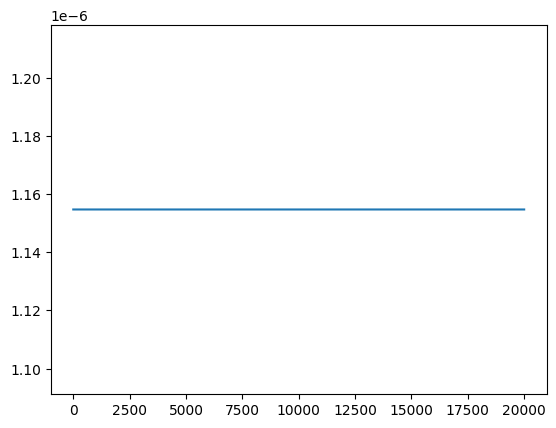

In [47]:
plt.plot(E) #Plot Energy

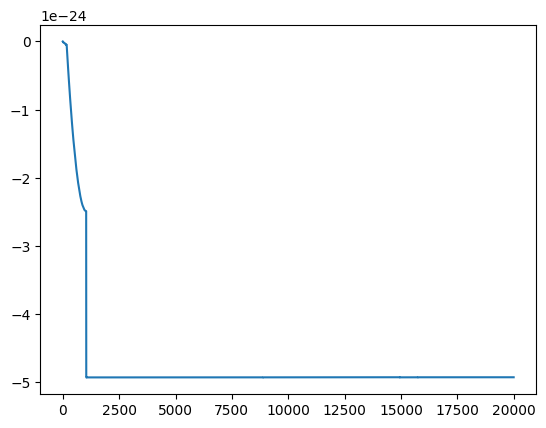

In [48]:
plt.plot(Phi) #Plot Angular Momentum